In [2]:
%matplotlib inline

import os
import sys

module_path = os.path.abspath(os.path.join('flavours-of-physics-start/'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import xgboost as xgb
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import *
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from evaluation import roc_auc_truncated, compute_ks, compute_cvm

sns.set(color_codes=True)

In [3]:
print('Loading the datasets...', end='')
train = pd.read_csv("data/training.csv")
test  = pd.read_csv("data/test.csv")
print('Done')

Loading the datasets...Done


In [4]:
def add_extra_features(df):
    df['FlightDistanceSig'] = df.FlightDistance / df.FlightDistanceError
    return df


# Use the provided scripts to create a score function
def score_function(estimator, X, y):
    prediction_prob = estimator.predict_proba(X)[:, 1]
    return roc_auc_truncated(y, prediction_prob)


def cross_validation(col):
    return StratifiedKFold(col, n_folds=5, shuffle=True)


def print_score_and_optimal_params(grid_scores):
    optimal_params, raw_score, _ = max(grid_scores, key=lambda x: x[1])
    print('Raw score: {}'.format(raw_score))
    print('Optimal parameters:')
    for p in optimal_params.keys():
        print('  {}: {}'.format(p, optimal_params[p]))
        

def score_result(check):
    return 'PASSED' if check else 'FAILED'
        
def verify_results(clf):
    agreement_probs = clf.predict_proba(check_agreement[features])[:,1]
    correlation_probs = clf.predict_proba(check_correlation[features])[:,1]
    train_filtered_probs = clf.predict_proba(train_filtered[features])[:,1]
    auc_score = roc_auc_truncated(train_filtered.signal, train_filtered_probs)

    ks = compute_ks(
        agreement_probs[check_agreement.signal.values == 0],
        agreement_probs[check_agreement.signal.values == 1],
        check_agreement[check_agreement.signal == 0]['weight'].values,
        check_agreement[check_agreement.signal == 1]['weight'].values
    )
    
    cvm = compute_cvm(correlation_probs, check_correlation.mass)

    print ('Agreement test (KS metric):', ks, score_result(ks < 0.09))
    print ('Correlation test (CvM metric):', cvm, score_result(cvm < 0.002))
    print ('AUC score: ', auc_score)
    
    
def create_submission_file(clf):
    test_probs = clf.predict_proba(test[features])[:,1]
    submission_df = pd.DataFrame({"id": test.id, "prediction": test_probs})
    submission_df.to_csv("submission.csv", index=False)
    print ('Created a submission file')

In [5]:
train = add_extra_features(train)
test = add_extra_features(test)

# Loading check agreement and check correlation for test evaluation
check_agreement = add_extra_features(pd.read_csv('data/check_agreement.csv'))
check_correlation = add_extra_features(pd.read_csv('data/check_correlation.csv'))
train_filtered = train[train.min_ANNmuon > 0.4]

# Remove variables, which fail the agreement test
exclude = ['id', 'min_ANNmuon', 'production', 'mass', 'signal', 
           'SPDhits', 'p0_track_Chi2Dof', 'CDF1', 'CDF2', 'CDF3',
           'isolationb', 'isolationc']

features = list(filter(lambda col: col not in exclude, train.columns))

print('Done')

Done


In [6]:
# Print some stats about the dataset
train[features].describe()

,LifeTime,dira,FlightDistance,FlightDistanceError,IP,IPSig,VertexChi2,pt,DOCAone,DOCAtwo,...,p0_pt,p1_pt,p2_pt,p0_p,p1_p,p2_p,p0_eta,p1_eta,p2_eta,FlightDistanceSig
count,67553.000000,67553.000000,67553.000000,67553.000000,67553.000000,67553.000000,67553.000000,67553.000000,6.755300e+04,6.755300e+04,...,67553.000000,67553.000000,67553.000000,67553.000000,67553.000000,67553.000000,67553.000000,67553.000000,67553.000000,67553.000000
mean,0.001255,0.999846,15.153986,0.501794,0.090363,5.305426,5.132504,5027.967460,4.496067e-02,3.760934e-02,...,1091.940617,2410.504448,1767.444110,15576.514356,33050.376570,24407.169131,3.280283,3.197816,3.233437,35.027967
std,0.000779,0.000540,15.060723,0.426345,0.085216,4.331420,3.849261,3010.766079,6.052672e-02,4.129047e-02,...,827.634015,1682.680723,1483.862981,14519.676963,30190.555855,25076.484396,0.592017,0.592466,0.588628,29.852255
min,0.000144,0.990090,0.804510,0.075224,0.000264,0.020823,0.001895,314.100067,9.142349e-08,2.434845e-08,...,300.024902,309.336365,300.038361,3001.942383,3052.763672,3008.329102,1.638945,1.673761,1.746441,1.761170
25%,0.000725,0.999916,6.225103,0.236352,0.027773,1.830687,1.995162,3157.041748,1.298088e-02,1.131008e-02,...,540.650085,1377.876587,789.605286,7022.408203,14357.550781,9325.879883,2.848309,2.746091,2.792214,17.594091
50%,0.001061,0.999985,10.604475,0.366318,0.058136,3.628297,4.116704,4366.348145,2.912052e-02,2.549105e-02,...,864.929077,2002.520996,1396.810303,11034.033203,23996.681641,16510.722656,3.249017,3.166046,3.205477,26.990024
75%,0.001559,0.999997,18.554255,0.598817,0.134010,8.221298,7.598480,6079.195801,5.754587e-02,4.908246e-02,...,1372.521484,2918.734863,2244.611084,18550.132812,40976.976562,30108.750000,3.688323,3.623785,3.647688,42.524686
max,0.022134,1.000000,449.242554,5.878616,2.245918,24.074131,14.998641,74390.289062,8.312201e+00,8.892956e-01,...,23757.583984,42049.773438,26444.507812,270323.250000,602064.750000,461608.593750,5.164036,5.090231,5.124544,776.847841


In [7]:
# Train the model
estimator = xgb.XGBClassifier()

parameters = {
    'n_jobs': [4],
    'silent': [1],
    'min_child_weight': [11],
    'max_depth': [7],
    'objective':['binary:logistic'],
    'learning_rate': [0.15],
    'n_estimators': [300],
    'subsample': [0.9],
    'colsample_bytree': [0.5],
}
    
# GridSearchCV is instantiated here to make it easier to search through the parameters
# but I have set the parameters to the optimal parameters I found to save on time.
print('Initializing Grid Search with XGBClassifier')
clf = GridSearchCV(estimator, parameters, n_jobs=4,
                   scoring=score_function, verbose=1,
                   cv=cross_validation(train_filtered.signal))

clf.fit(train[features], train.signal)

print_score_and_optimal_params(clf.grid_scores_)
verify_results(clf)
create_submission_file(clf)

Initializing Grid Search with XGBClassifier
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   53.6s finished


Raw score: 0.9865279286524576
Optimal parameters:
  colsample_bytree: 0.5
  learning_rate: 0.15
  max_depth: 7
  min_child_weight: 11
  n_estimators: 300
  n_jobs: 4
  objective: binary:logistic
  silent: 1
  subsample: 0.9
Agreement test (KS metric): 0.0884024743958 PASSED
Correlation test (CvM metric): 0.000897765109717 PASSED
AUC score:  0.998252648534
Created a submission file


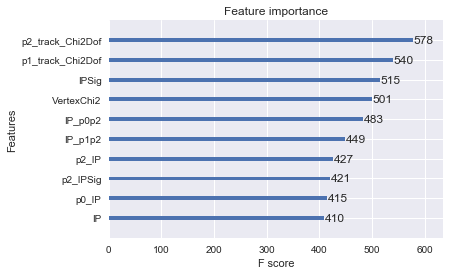

In [8]:
# Create XGBClassifier with optimal parameters in order to obtain feature importance
model = xgb.XGBClassifier(
    colsample_bytree=0.5, n_jobs=4, objective='binary:logistic', max_depth=7,
    subsample=0.9, n_estimators=300, min_child_weight=11, learning_rate=0.15
)
model.fit(train[features], train.signal)

# Display plot of 10 most important features
xgb.plot_importance(model, max_num_features=10)

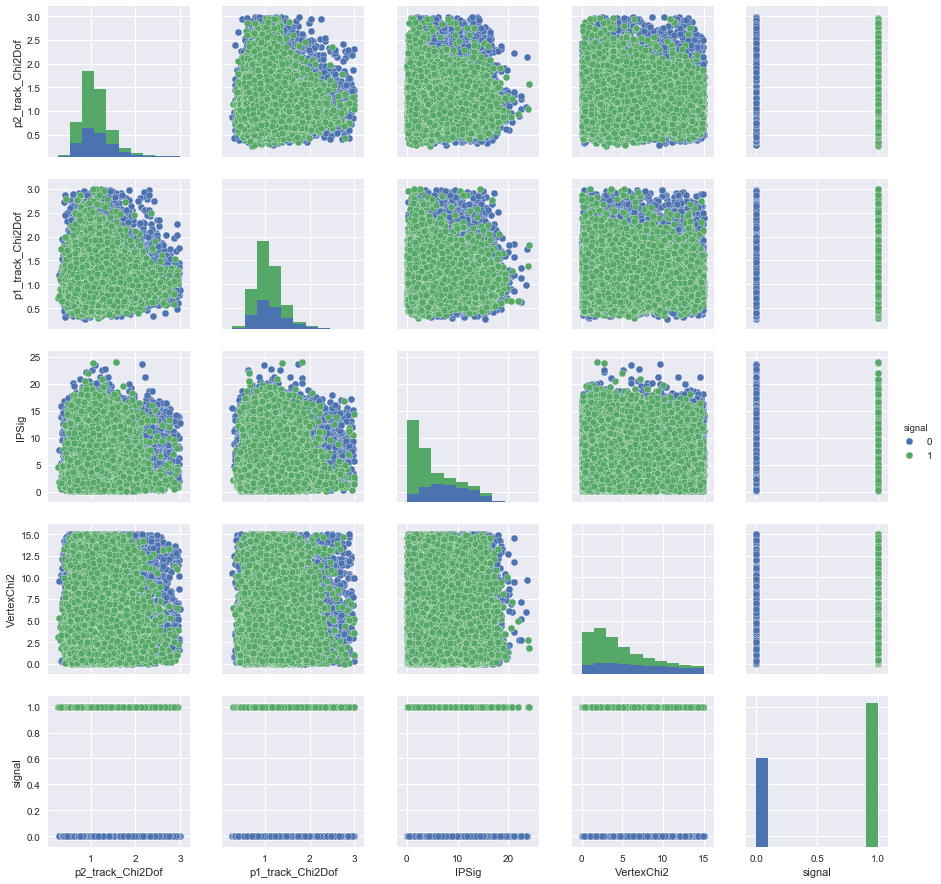

In [10]:
# Display pairplot of 4 most important features
columns = ["p2_track_Chi2Dof", "p1_track_Chi2Dof", "IPSig", "VertexChi2", "signal"]
sns.pairplot(train[columns], hue="signal")

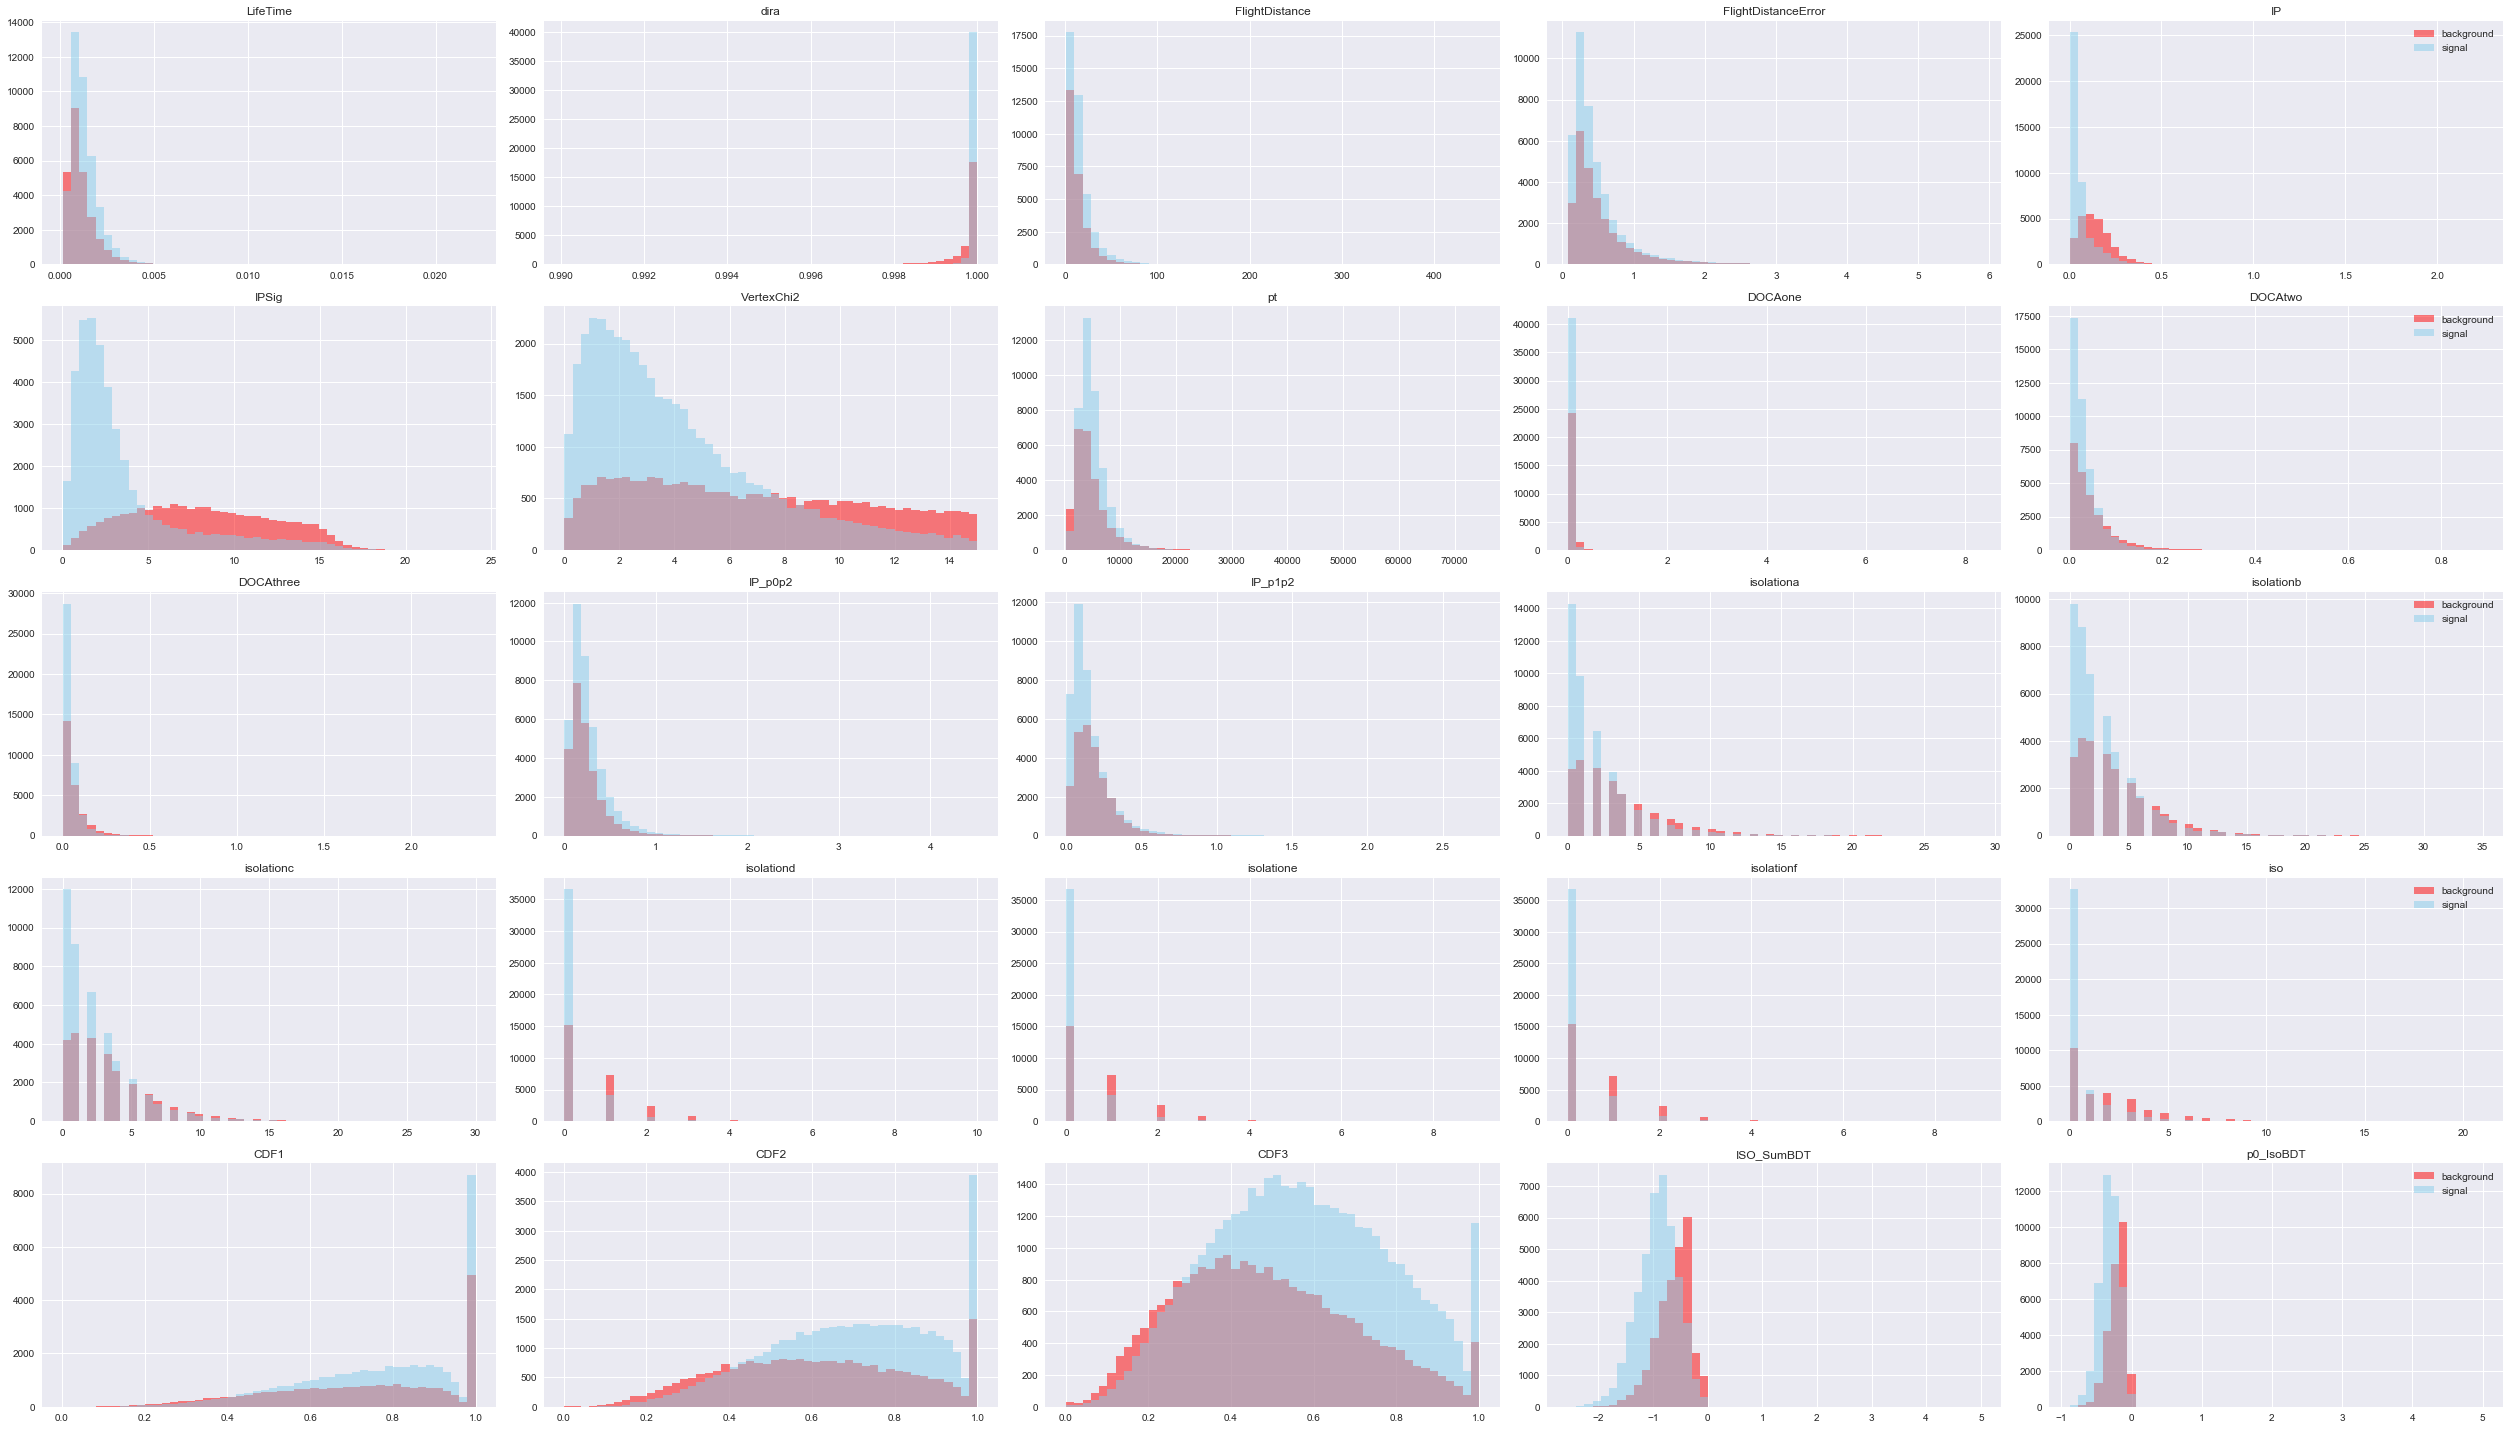

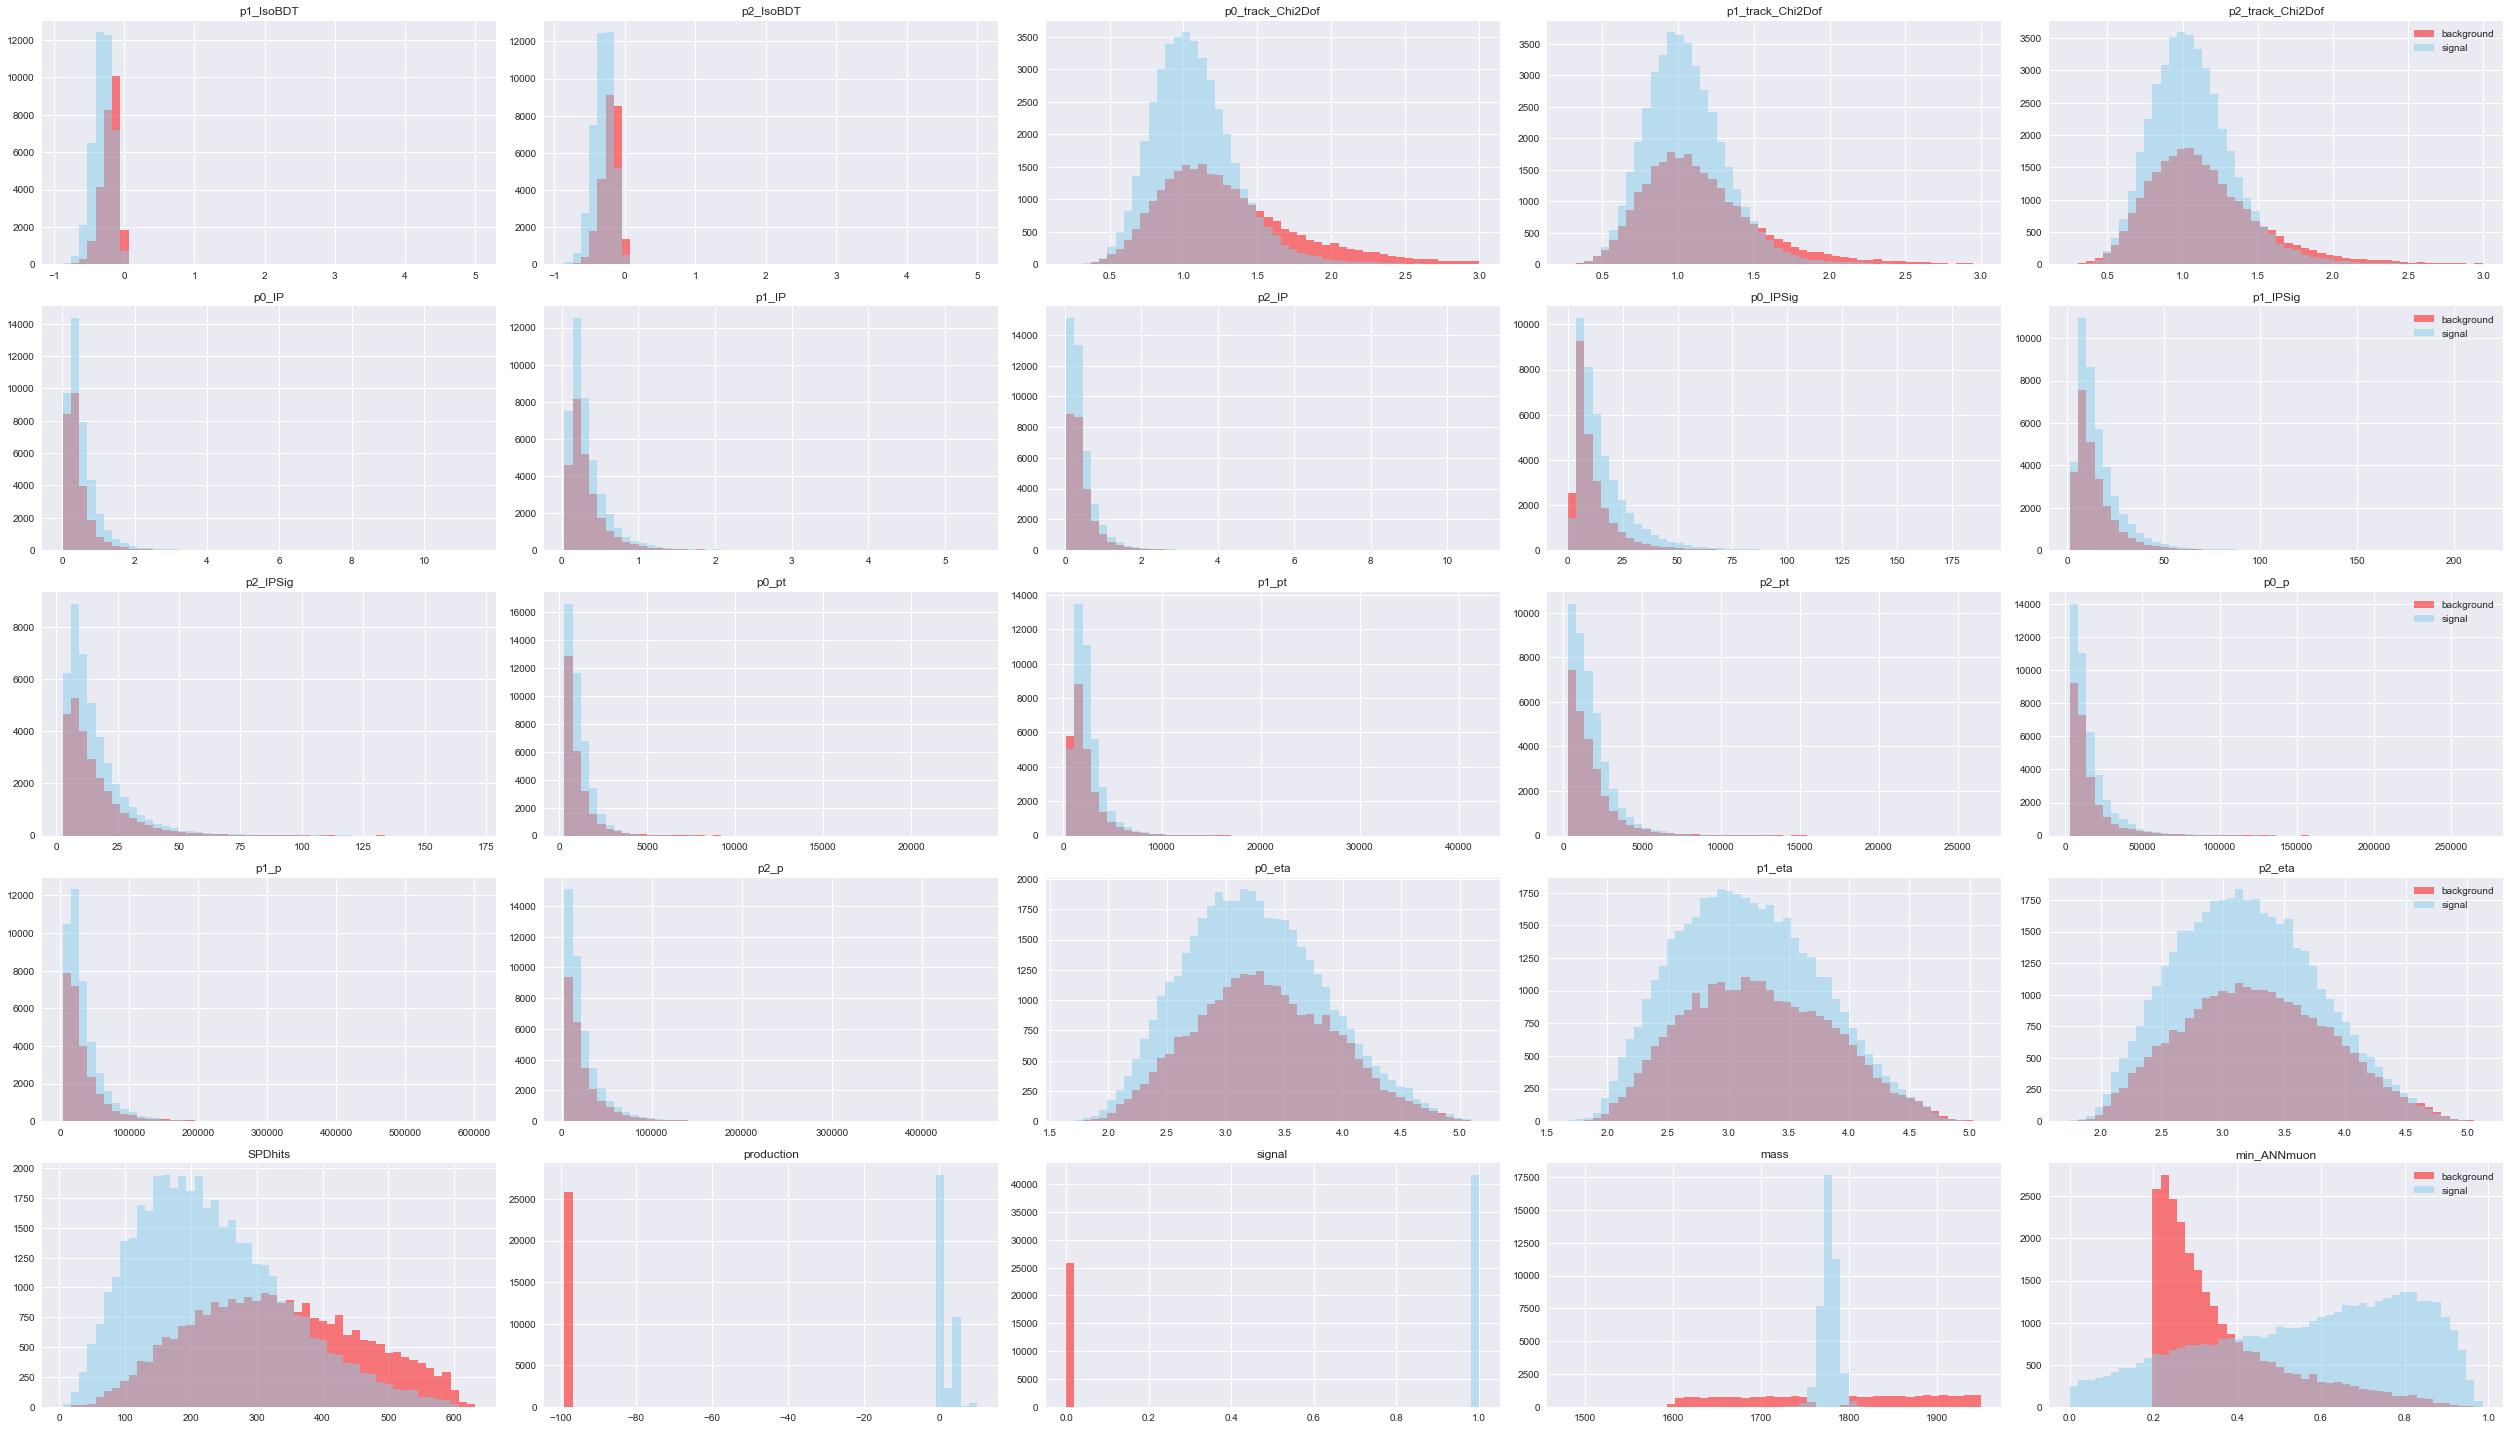

In [11]:
def plot_histograms(train):
    for n in range(2):
      fig = plt.figure(figsize=(35,20))

      for i in range(1,26):
        ax = fig.add_subplot(5, 5, i)
        col = train.columns[i + 25*n]
        ax.set_title(col)

        plt.hist(
            [
                train[train['signal'] == 1][col],
                train[train['signal'] == 0][col]
            ], 
            bins=50,
            histtype='stepfilled',
            color=['skyblue', 'red'],
            alpha=0.5,
            label=['signal', 'background']
        )    
        if (i % 5 == 0): ax.legend()

      fig.tight_layout(pad=1, w_pad=1, h_pad=1)
        

plot_histograms(train)

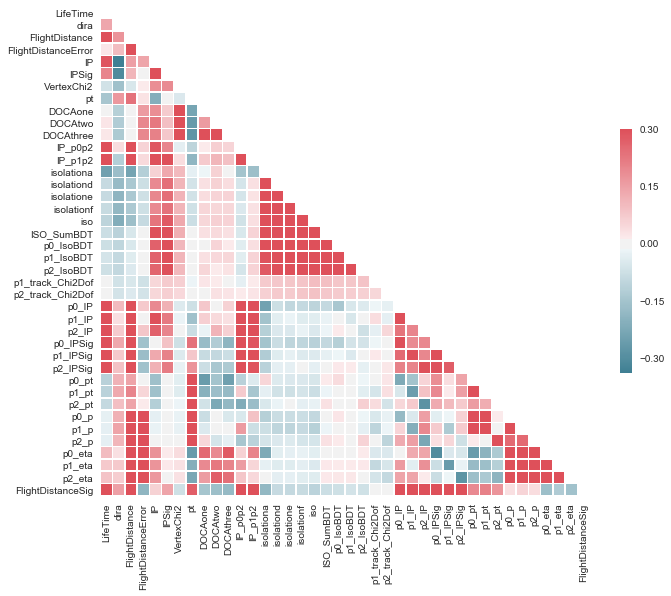

In [12]:
sns.set(style="white")

# Compute the correlation matrix
corr = train[features].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})